### Task #4
(Image Quality Analysis – is based on materials of the lecture/lab on 06.10)
1. Collect the dataset of 20 color images from open sources. It can be various  images of people/pets/nature/city etc.
2. Sort these images in the descending order according to your personal opinion about its perceptual quality https://en.wikipedia.org/wiki/Image_quality. For example, mark them from 5 to 1, where 5=excellent quality, 1=poor quality. Plot the marks as a captions for the images in the Notebook.
3.  Evaluate No-Reference image quality metrics TV, BRISQUE and NIMA estimating their quality (use, for example, implementations from https://github.com/photosynthesis-team/piq, https://github.com/aigagror/ML-Aesthetics-NIMA).
4. Compute Pearson correlation coefficients between the metric scores and your personal estimates.
5. Choose the best metric, which is more correlated with the human opinion.
6. Complete a task in a single Jupyter Notebook.


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
from scipy.stats.stats import pearsonr

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
base_directory = './data/'
dataset = []

# our marks ranges from 2 to 5
for mark in range(2, 6):
    mark_directory = os.path.join(base_directory, str(mark))

    if os.path.exists(mark_directory) and os.path.isdir(mark_directory):
        files = os.listdir(mark_directory)

        for file in files:
            file_path = os.path.join(mark_directory, file)
            dataset.append({'name': file, 'path': file_path, 'mark': str(mark)})


## the data marked based on the resolution and perceptual quality.

In [5]:
df = pd.DataFrame(dataset)
df = df.loc[df['name']!='.DS_Store']

## Plotting the data and marks

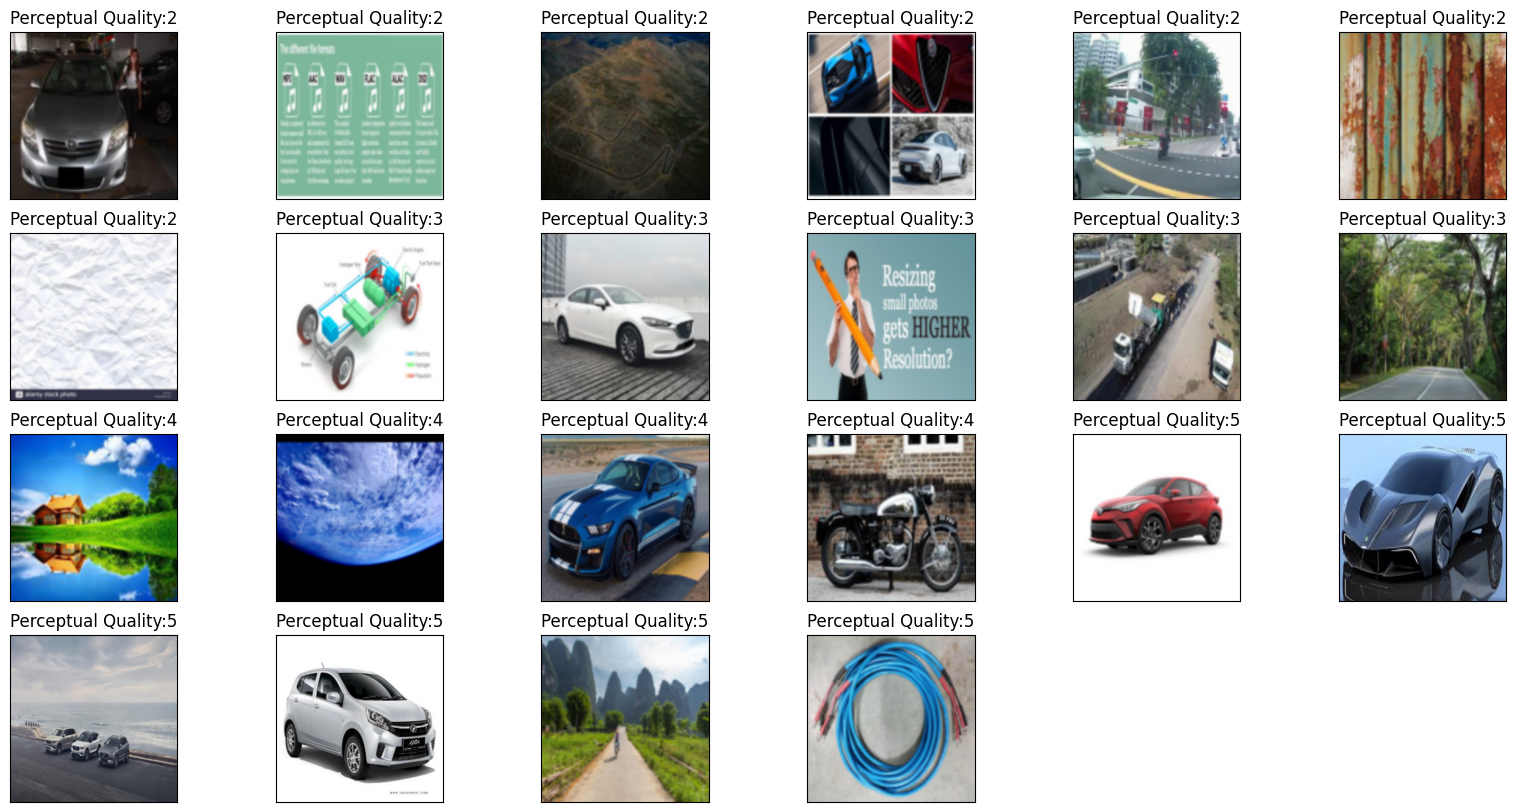

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for i in range(len(df)):
    image = plt.imread(df.iloc[i, 1])
    plt.subplot(4, 6, i + 1)
    plt.imshow(image)
    plt.title(f'Perceptual Quality:{df.iloc[i, 2]}')
    plt.xticks([])
    plt.yticks([])

## 3.  Evaluate No-Reference image quality metrics TV, BRISQUE and NIMA estimating their quality

In [7]:
from brisque import BRISQUE
brisq = BRISQUE()

## Get BRISQUE metric

In [10]:
brisq_scores = []
for i in df.path.values:
  brisq_scores.append(brisq.get_score(i))

df['brisq'] = brisq_scores

## Getting TV metric

In [11]:
import cv2
import numpy as np

def calculate_tv_score(image_path):
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load the image at {image_path}")
        return None

    # Calculate the Total Variation (TV) score
    tv_score = np.sum(np.abs(np.gradient(image)))

    return tv_score

# List of image paths
image_paths = df.path.values

# Calculate TV scores for each image
tv_scores = []
for image_path in image_paths:
    tv_score = calculate_tv_score(image_path)
    if tv_score is not None:
        tv_scores.append(tv_score)

df['TV'] = np.array(tv_scores)/10000 # make it easier to compare

In [12]:
df

,name,path,mark,brisq,TV
0,58.png,./data/2/58.png,2,51.491821,204.70490
1,64.png,./data/2/64.png,2,59.119150,679.78640
2,40.png,./data/2/40.png,2,41.760929,245.46230
3,33.png,./data/2/33.png,2,43.458630,488.78780
4,74.png,./data/2/74.png,2,50.853736,397.87650
5,26.png,./data/2/26.png,2,31.857708,816.23770
6,39.png,./data/2/39.png,2,50.173872,173.88305
7,109.png,./data/3/109.png,3,56.548604,268.74180
8,108.png,./data/3/108.png,3,68.268695,212.15985
9,38.png,./data/3/38.png,3,51.599345,582.04945


## Getting NIMA scores

In [22]:
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from path import Path

def mean_score(scores):
    si = np.arange(1, 11, 1)
    mean = np.sum(scores * si)
    return mean

def std_score(scores):
    si = np.arange(1, 11, 1)
    mean = mean_score(scores)
    std = np.sqrt(np.sum(((si - mean) ** 2) * scores))
    return std

imgs = df.path.values
target_size = (224, 224)

with tf.device('/CPU:0'):
    base_model = MobileNet((None, None, 3), alpha=1, include_top=False, pooling='avg', weights=None)
    x = Dropout(0.75)(base_model.output)
    x = Dense(10, activation='softmax')(x)

    model = Model(base_model.input, x)
    model.load_weights('./mobilenet_weights.h5')

    score_list = []

    for img_path in imgs:
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        x = preprocess_input(x)

        scores = model.predict(x, batch_size=1, verbose=0)[0]

        mean = mean_score(scores)
        std = std_score(scores)

        file_name = Path(img_path).name.lower()
        score_list.append(mean)

df['NIMA'] = score_list

In [23]:
df

,name,path,mark,brisq,TV,NIMA
0,58.png,./data/2/58.png,2,51.491821,204.70490,3.704157
1,64.png,./data/2/64.png,2,59.119150,679.78640,5.374876
2,40.png,./data/2/40.png,2,41.760929,245.46230,4.091776
3,33.png,./data/2/33.png,2,43.458630,488.78780,4.722992
4,74.png,./data/2/74.png,2,50.853736,397.87650,4.317741
5,26.png,./data/2/26.png,2,31.857708,816.23770,4.665813
6,39.png,./data/2/39.png,2,50.173872,173.88305,4.370149
7,109.png,./data/3/109.png,3,56.548604,268.74180,4.377243
8,108.png,./data/3/108.png,3,68.268695,212.15985,4.617301
9,38.png,./data/3/38.png,3,51.599345,582.04945,4.926910


## Calculate pearson correlation coefficients

In [27]:
df['mark'] = df['mark'].astype(int)

print(f'Corr coeff for mark and brisq: {pearsonr(df.mark.values, df.brisq.values)[0]}')

Corr coeff for mark and brisq: 0.007256941954074572


In [28]:
print(f'Corr coeff for mark and TV: {pearsonr(df.mark.values, df.TV.values)[0]}')

Corr coeff for mark and TV: 0.11250681660084033


In [29]:
print(f'Corr coeff for mark and NIMA: {pearsonr(df.mark.values, df.NIMA.values)[0]}')

Corr coeff for mark and NIMA: 0.41559616819974843


# Results:

## Correlation between Mark and BRISQUE: 0.0073
* The correlation coefficient between the human-labeled marks and BRISQUE scores is very close to zero (positive but negligible). This suggests a weak correlation, indicating that BRISQUE has a limited ability to predict or match the human perceptual quality marks. It may not be very accurate in this context.

## Correlation between Mark and TV: 0.1125
* The correlation coefficient between the human-labeled marks and TV scores is also relatively low but higher than BRISQUE. It indicates a weak positive correlation, meaning that TV is somewhat better at capturing the human perception of image quality compared to BRISQUE. However, it's still a weak correlation.

## Correlation between Mark and NIMA: 0.4156
* The correlation coefficient between the human-labeled marks and NIMA scores is the highest among the three metrics. It indicates a moderate positive correlation, suggesting that NIMA is better at approximating the human perception of image quality compared to BRISQUE and TV. A higher correlation suggests that NIMA is a more accurate metric for predicting image quality.


## Conclusion:

Based on the correlation coefficients, NIMA appears to be the most accurate image quality assessment metric among the three in approximating the human perception of image quality. It has a moderate positive correlation with the human-labeled marks, indicating that it aligns better with human judgments. However, it's important to note that even NIMA does not have a perfect correlation. It can be caused be the fact that I picked random pictures, which do not have specific topic.